## TRAINING NOTEBOOK

In [1]:
# load modules

import os
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import Model 
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
SEED = 1234
tf.random.set_seed(SEED) 

This is the real-time augmentation configuration we will use for training and validation and configuring random transformations and normalization operations to be done on the image data during training


In [3]:

train_data_gen = ImageDataGenerator(rotation_range=50,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.3,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='constant',
                                    cval=0,
                                    rescale=1./255)

valid_data_gen = ImageDataGenerator(rotation_range=45,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.3,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='constant',
                                    cval=0,
                                    rescale=1./255)

Defining Data Parameters

In [4]:
# our root dataset dir path
dataset_dir =  "../dataset/"

# batch size
Batch_size = 64

# dimensions of our images.
img_h = 256
img_w = 256

# the total classes
num_classes=7

# the labels indexes
classes = [
    'boots', # 0
    'flip_flops',# 1
    'loafers',# 2
    'sandals',# 3
    'sneakers',# 4
    'soccer_shoes',# 5
    'no_shoe'# 6
           ]

Instantiating generators of augmented image batches (and their labels)

In [5]:
# Training 

training_dir = os.path.join(dataset_dir, 'train')
train_gen = train_data_gen.flow_from_directory(training_dir,
                                               target_size=(256, 256),
                                               batch_size=Batch_size,
                                               classes=classes,
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=SEED)

# Validation

valid_dir = os.path.join(dataset_dir, 'test')
valid_gen = valid_data_gen.flow_from_directory(valid_dir,
                                           target_size=(256, 256),
                                           batch_size=Batch_size, 
                                           classes=classes,
                                           class_mode='categorical',
                                           shuffle=False,
                                           seed=SEED)

Found 2800 images belonging to 7 classes.
Found 1050 images belonging to 7 classes.


Plotting our images

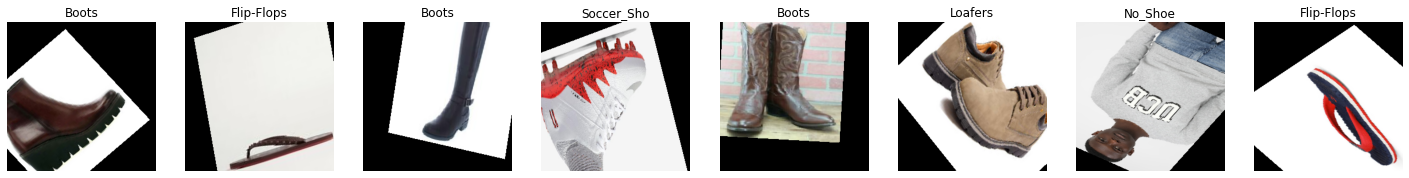

In [6]:
CLASS_NAMES = np.array(['boots', 'flip-flops','loafers','sandals','sneakers','soccer_shoes','no_shoe'], dtype='<U10')

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(25,20))
    for n in range(8):
        ax = plt.subplot(1,8,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')

image_batch, label_batch = next(train_gen)
show_batch(image_batch, label_batch)


## Transfer Learning
We will be using Transfer Learning for training.

Transfer learning consists of taking features learned on one problem, and leveraging them on a new, similar problem
.Transfer learning is usually done for tasks where your dataset has too little data to train a full-scale model from scratch.

The most common incarnation of transfer learning in the context of deep learning is the following worfklow:

1. Take layers from a previously trained model.
2. Freeze them, so as to avoid destroying any of the information they contain during future training rounds.
3. Add some new, trainable layers on top of the frozen layers. They will learn to turn the old features into predictions on a new dataset.
4. Train the new layers on your dataset.

Find more about transfer learning model in keras [here](https://pytorch.org/vision/stable/models.html)

We will be using ResNet152 a model pre-trained on ImageNet which was described [here](https://arxiv.org/abs/1512.03385)

In [7]:
ResNet_model = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))

The last 15 layers fine tune and set the last 15 layers (up to the last conv block) to non-trainable (weights will not be updated)

In [8]:
for layer in ResNet_model.layers[:-15]:
    layer.trainable = False

x = ResNet_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
output  = Dense(units=num_classes, activation='softmax')(x)
model = Model(ResNet_model.input, output)


model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 130, 130, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

conv4_block15_1_relu (Activatio (None, 16, 16, 256)  0           conv4_block15_1_bn[0][0]         
__________________________________________________________________________________________________
conv4_block15_2_pad (ZeroPaddin (None, 18, 18, 256)  0           conv4_block15_1_relu[0][0]       
__________________________________________________________________________________________________
conv4_block15_2_conv (Conv2D)   (None, 16, 16, 256)  589824      conv4_block15_2_pad[0][0]        
__________________________________________________________________________________________________
conv4_block15_2_bn (BatchNormal (None, 16, 16, 256)  1024        conv4_block15_2_conv[0][0]       
__________________________________________________________________________________________________
conv4_block15_2_relu (Activatio (None, 16, 16, 256)  0           conv4_block15_2_bn[0][0]         
__________________________________________________________________________________________________
conv4_bloc

Model Parameters
- CategoricalCrossentropy Loss
- Adam Optimizer
- Accuracy Metric
- Reducing Plateau and Early stopping based on val_accuracy

In [9]:
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=loss, metrics= ['accuracy'])

In [10]:
lrr = ReduceLROnPlateau(monitor='val_accuracy', 
                        patience=3, 
                        verbose=1, 
                        factor=0.4, 
                        min_lr=0.0001)


callbacks = [lrr]

# no of epochs for the model to run
no_of_epochs = 10

# Step sizes for train and validation data

STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
STEP_SIZE_VALID=valid_gen.n//valid_gen.batch_size

transfer_learning_history = model.fit_generator(generator=train_gen,
                   steps_per_epoch=STEP_SIZE_TRAIN,
                   validation_data=valid_gen,
                   validation_steps=STEP_SIZE_VALID,
                   epochs=no_of_epochs,
                   callbacks=callbacks)

c:\anaconda3\envs\tensor2\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
43/43 [==============================] - 1672s 38s/step - loss: 0.8212 - accuracy: 0.7105 - val_loss: 4.6178 - val_accuracy: 0.6855
Epoch 2/10
43/43 [==============================] - 1571s 37s/step - loss: 0.4975 - accuracy: 0.8326 - val_loss: 1.2148 - val_accuracy: 0.7715
Epoch 3/10
43/43 [==============================] - 1568s 37s/step - loss: 0.4395 - accuracy: 0.8505 - val_loss: 1.8139 - val_accuracy: 0.7178
Epoch 4/10
43/43 [==============================] - 1564s 37s/step - loss: 0.3332 - accuracy: 0.8845 - val_loss: 0.9733 - val_accuracy: 0.7676
Epoch 5/10
43/43 [==============================] - 1544s 36s/step - loss: 0.3376 - accuracy: 0.8904 - val_loss: 0.8304 - val_accuracy: 0.7471

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
Epoch 6/10
43/43 [==============================] - 1546s 36s/step - loss: 0.2484 - accuracy: 0.9207 - val_loss: 0.6224 - val_accuracy: 0.8242
Epoch 7/10
43/43 [==============================] - 1573s 37s

Plotting Learning Curves

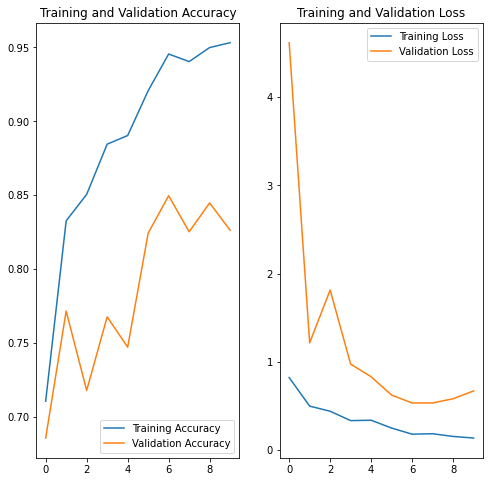

In [12]:
acc = transfer_learning_history.history['accuracy']
val_acc = transfer_learning_history.history['val_accuracy']

loss = transfer_learning_history.history['loss']
val_loss = transfer_learning_history.history['val_loss']

epochs_range = range(no_of_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Save Trained Model for further Inference

In [13]:
model.save('../trained_model_imagenet')

c:\anaconda3\envs\tensor2\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: ../trained_model_imagenet\assets


Validating on the Validation Set

In [15]:
preds = model.predict(valid_gen,verbose=1)
y_preds = np.argmax(preds,axis=1)
y_trues = valid_gen.classes

17/17 [==============================] - 364s 21s/step


Evaluation Metrics

In [16]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_trues, y_preds)
print("Node \t precision \t recall \t fscore \t support")
for i,dat in enumerate(zip(precision,recall,fscore,support)):
    print('{} \t {:.4f} \t {:.4f} \t {:.4f} \t {:.4f}'.format(i,dat[0],dat[1],dat[2],dat[3]))

Node 	 precision 	 recall 	 fscore 	 support
0 	 0.9510 	 0.6467 	 0.7698 	 150.0000
1 	 0.8605 	 0.7400 	 0.7957 	 150.0000
2 	 0.8438 	 0.9000 	 0.8710 	 150.0000
3 	 0.8146 	 0.8200 	 0.8173 	 150.0000
4 	 0.6557 	 0.8000 	 0.7207 	 150.0000
5 	 0.8286 	 0.9667 	 0.8923 	 150.0000
6 	 1.0000 	 1.0000 	 1.0000 	 150.0000


In [17]:
from sklearn.metrics import f1_score
f1_score(y_trues, y_preds,average='micro') # F1 Score - micro

0.839047619047619